# R4 on Salient ImageNet

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import tqdm
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))
from models.R4_models import SalientImageNet, SeqSalientImageNet
from models.pipeline import (train_model_with_certified_input_grad, train_model_with_pgd_robust_input_grad,
                             accumulate_model_with_certified_input_grad, test_model_accuracy, test_delta_input_robustness,
                             write_results_to_file, uniformize_magnitudes_schedule)
from datasets import salient_imagenet
from metrics import worst_group_acc

# Get the dataloaders 

In [2]:
CUDA_LAUNCH_BLOCKING=1
SEED = 0
DELTA_INPUT_ROBUSTNESS_PARAM = 1
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(SEED)
batch_size = 256
test_batch_size = 64

cuda:1


In [3]:
# isic_save_path = "/vol/bitbucket/mg2720/isic/isic.pt"
# [isic_input_tensors, isic_labels] = torch.load(isic_save_path, mmap=True)
DATA_DIR = "/vol/bitbucket/mg2720/imagenet100_data"
MASKS_DIR = "/vol/bitbucket/mg2720/salient_imagenet_dataset"

# train_imgnet = salient_imagenet.ImageNetDataset(DATA_DIR, MASKS_DIR, True)
# test_imgnet = salient_imagenet.ImageNetDataset(DATA_DIR, MASKS_DIR, False)
train_imgnet = salient_imagenet.LazyImageNetDataset(DATA_DIR, MASKS_DIR, True)
test_imgnet = salient_imagenet.LazyImageNetDataset(DATA_DIR, MASKS_DIR, False)
print(len(train_imgnet), len(test_imgnet))
print(train_imgnet[0][0].shape)


6297 2099
torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
3
torch.Size([3, 224, 224])
tensor(2.6226) tensor(-2.1008)
tensor(0)


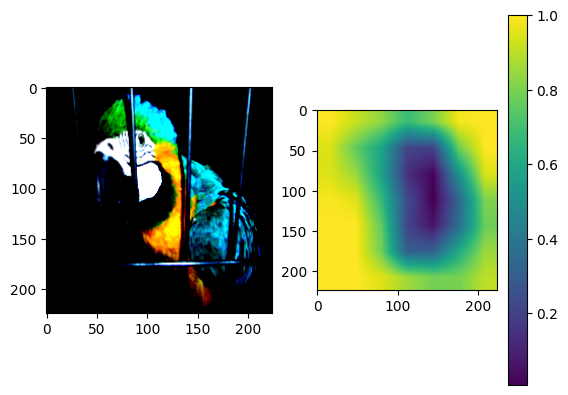

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3
torch.Size([3, 224, 224])
tensor(2.2566) tensor(-2.1008)
tensor(1)


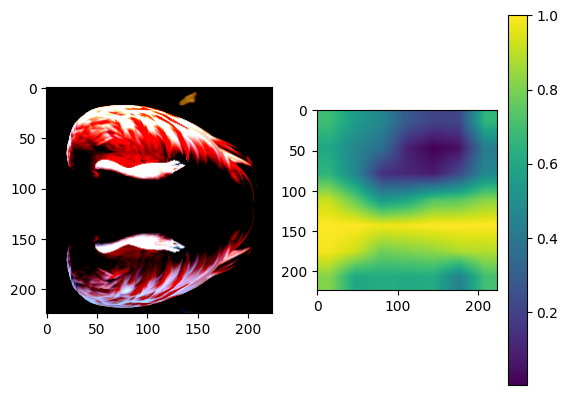

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3
torch.Size([3, 224, 224])
tensor(2.2489) tensor(-2.1179)
tensor(1)


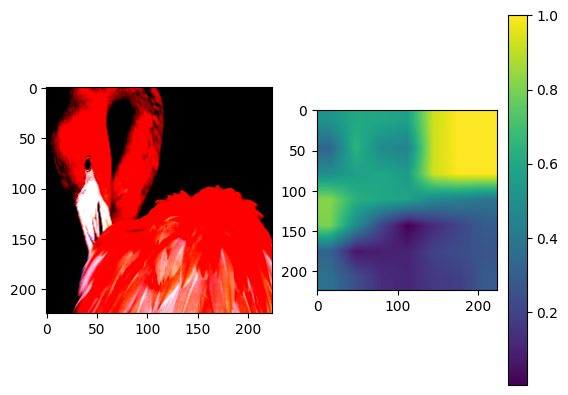

In [4]:
print((train_imgnet[0][2]).shape)
img, img_label, img_mask = None, None, None
rand_5 = torch.randint(0, len(train_imgnet), (10,))
for i in rand_5:
    img, img_label, img_mask = train_imgnet[i]
    if not torch.all(img_mask[0] == 0):
        print(img_mask.shape[0])
        print(img.shape)
        print(torch.max(img), torch.min(img))
        print(img_label)
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(img.float().permute(1, 2, 0).squeeze().numpy())
        im_mask = ax[1].imshow(img_mask[0].numpy())
        fig.colorbar(im_mask, ax=ax[1])
        plt.show()

In [5]:
dl_train = salient_imagenet.get_dataloader(train_imgnet, batch_size)
dl_test = salient_imagenet.get_dataloader(test_imgnet, test_batch_size)
criterion = torch.nn.CrossEntropyLoss()

In [19]:
num_classes = 6
train_labels_per_class = [0] * num_classes
for label_idx in range(num_classes):
    train_labels_per_class[label_idx] = dl_test.dataset.label_tensors[dl_test.dataset.label_tensors == label_idx].shape[0]
print(train_labels_per_class)


[333, 354, 351, 351, 372, 338]


## Experiments 

In [6]:
model_root_save_dir = "saved_experiment_models/performance/imagenet"
os.makedirs(model_root_save_dir, exist_ok=True)
methods = ["r4", "pgd_ex", "pgd_ex+r3", "std", "r3"]
save_dir_for_method = {method: os.path.join(model_root_save_dir, method) for method in methods}
for method in methods:
    os.makedirs(save_dir_for_method[method], exist_ok=True)

### Standard Training

In [ ]:
std_method = "std"
# Hyperparameters
num_epochs, lr, restarts, epsilon, k, weight_coeff = 2, 2e-4, 1, 0.1, -1, -1
# k is a coefficient for the regularization term
train_acc, test_acc = 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = SalientImageNet(6)
    print(f"========== Training model with method {std_method} restart {i} ==========")
    train_model_with_pgd_robust_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, std_method, k, device)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device, multi_class=True)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[std_method], f"run_{i}.pt"))
empty_model = SalientImageNet(6)
wg_acc, wg = worst_group_acc(empty_model, dl_test, device, 6, save_dir_for_method[std_method])
write_results_to_file("experiment_results/imagenet.yaml",
                      {"train_acc": round(train_acc / restarts, 3),
                       "test_acc": round(test_acc / restarts, 3),
                       "worst_group_acc": round(wg_acc / restarts, 3),
                       "worst_group": wg}, std_method)
write_results_to_file("experiment_results/imagenet_params.yaml",
                        {"epsilon": epsilon,
                         "k": k,
                         "weight_coeff": weight_coeff,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts}, std_method)

========== Training model with method std restart 0 ==========


Epoch: 100%|██████████| 2/2 [05:25<00:00, 162.74s/it, loss=1.05, reg=0]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 1
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.98
Worst class accuracy = 0.3107 for class 5


### RRR Training

In [ ]:
# Train standard 3 times and test accuracy and delta input robustness for the masked region
rrr_method = "r3"
num_epochs, lr, restarts, epsilon, k, weight_coeff = 5, 2e-4, 1, 0.1, 0.5, 1e-4
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = SalientImageNet(6)
    print(f"========== Training model with method {rrr_method} restart {i} ==========")
    train_model_with_pgd_robust_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, rrr_method,
        k, device, weight_reg_coeff=weight_coeff)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device, multi_class=True)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[rrr_method], f"run_{i}.pt"))
empty_model = SalientImageNet(6)
wg_acc, wg = worst_group_acc(empty_model, dl_test, device, 6, save_dir_for_method[rrr_method])
write_results_to_file("experiment_results/imagenet.yaml",
                        {"train_acc": round(train_acc / restarts, 3),
                         "test_acc": round(test_acc / restarts, 3),
                         "worst_group_acc": round(wg_acc / restarts, 3),
                         "worst_group": wg}, rrr_method)
write_results_to_file("experiment_results/imagenet_params.yaml",
                        {"epsilon": epsilon,
                         "k": k,
                         "weight_coeff": weight_coeff,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,}, rrr_method)


========== Training model with method r3 restart 0 ==========


Epoch: 100%|██████████| 5/5 [14:58<00:00, 179.65s/it, loss=3.13, reg=tensor(2.0833, device='cuda:1', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 1
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.99
Worst class accuracy = 0.3277 for class 1


### R4 Training

In [ ]:
r4_method = "r4"
criterion = torch.nn.CrossEntropyLoss()
num_epochs, lr, restarts, epsilon, k, weight_coeff = 14, 2e-4, 3, 0.01, 0.01, -1
train_acc, test_acc, num_robust, min_robust_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 1e+8, 0, 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = SalientImageNet(3, 6)
    print(f"========== Training model with method {r4_method} restart {i} ==========")
    train_model_with_certified_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, r4_method,
        k, device, True)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device, multi_class=True)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM,
        "cross_entropy", device, has_conv=True)
    num_robust += num_robust
    min_robust_delta = min(min_robust_delta, min_delta)
    min_lower_bound += m_l
    max_upper_bound += m_u
write_results_to_file("experiment_results/imagenet.yaml",
                      {"train_acc": round(train_acc / restarts, 3),
                       "test_acc": round(test_acc / restarts, 3),
                       "num_robust": round(num_robust / restarts, 3),
                       "min_lower_bound": round(min_lower_bound / restarts, 3),
                       "max_upper_bound": round(max_upper_bound / restarts, 3),
                       "min_robust_delta": min_robust_delta}, r4_method)
write_results_to_file("experiment_results/imagenet_params.yaml",
                        {"epsilon": epsilon,
                         "k": k,
                         "weight_coeff": weight_coeff,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,
                         "delta_threshold": DELTA_INPUT_ROBUSTNESS_PARAM}, r4_method)

### IBP-Ex Training

In [ ]:
data_dir = "/vol/bitbucket/mg2720/imagenet100_data"
masks_dir = "/vol/bitbucket/mg2720/salient_imagenet_dataset"
train_dset = salient_imagenet.LazyImageNetDataset(data_dir, masks_dir, True)
test_dset = salient_imagenet.LazyImageNetDataset(data_dir, masks_dir, False)
dl_train = salient_imagenet.get_dataloader(train_dset, 10)
num_dynamic_per_batch = 5
dl_test = salient_imagenet.get_dataloader(test_dset, 25)
ibp_ex = "ibp_ex"
criterion = torch.nn.CrossEntropyLoss()
num_epochs, lr, restarts, epsilon, k, weight_coeff = 13, 2e-4, 3, 0.01, 0.01, 2e-4
train_acc, test_acc, num_robust, min_robust_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 1e+8, 0, 0
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = SalientImageNet(3, 6)
    print(f"========== Training model with method {ibp_ex} restart {i} ==========")
    accumulate_model_with_certified_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, ibp_ex,
        k, device, True, num_accs=num_dynamic_per_batch)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device, multi_class=True)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM,
        "cross_entropy", device, has_conv=True)
    num_robust += num_robust
    min_robust_delta = min(min_robust_delta, min_delta)
    min_lower_bound += m_l
    max_upper_bound += m_u
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[ibp_ex], f"model_{i}.pt"))
write_results_to_file("experiment_results/imagenet.yaml",
                      {"train_acc": round(train_acc / restarts, 3),
                       "test_acc": round(test_acc / restarts, 3),
                       "num_robust": round(num_robust / restarts, 3),
                       "min_lower_bound": round(min_lower_bound / restarts, 3),
                       "max_upper_bound": round(max_upper_bound / restarts, 3),
                       "min_robust_delta": min_robust_delta}, ibp_ex)
write_results_to_file("experiment_results/imagenet_params.yaml",
                        {"epsilon": epsilon,
                         "k": k,
                         "weight_coeff": weight_coeff,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,
                         "delta_threshold": DELTA_INPUT_ROBUSTNESS_PARAM}, ibp_ex)